Grid-based Material Analysis

SI3N4:
  Position: (76, 36) to (179, 51)
  Width: 104 pixels
  Height: 16 pixels
  Area: 1427 pixels
  Pixel count: 1427

SIO2:
  Position: (20, 52) to (235, 82)
  Width: 216 pixels
  Height: 31 pixels
  Area: 6511 pixels
  Pixel count: 6511

SI:
  Position: (20, 83) to (235, 161)
  Width: 216 pixels
  Height: 79 pixels
  Area: 16976 pixels
  Pixel count: 16976

Material Distribution Analysis:

SI3N4:
  Total pixels: 1427
  X range: 76 to 179
  Y range: 36 to 51
  Center: (127.5, 43.5)

SIO2:
  Total pixels: 6511
  X range: 20 to 235
  Y range: 52 to 82
  Center: (127.5, 67.0)

SI:
  Total pixels: 16976
  X range: 20 to 235
  Y range: 83 to 161
  Center: (127.5, 122.0)

Creating visualization...


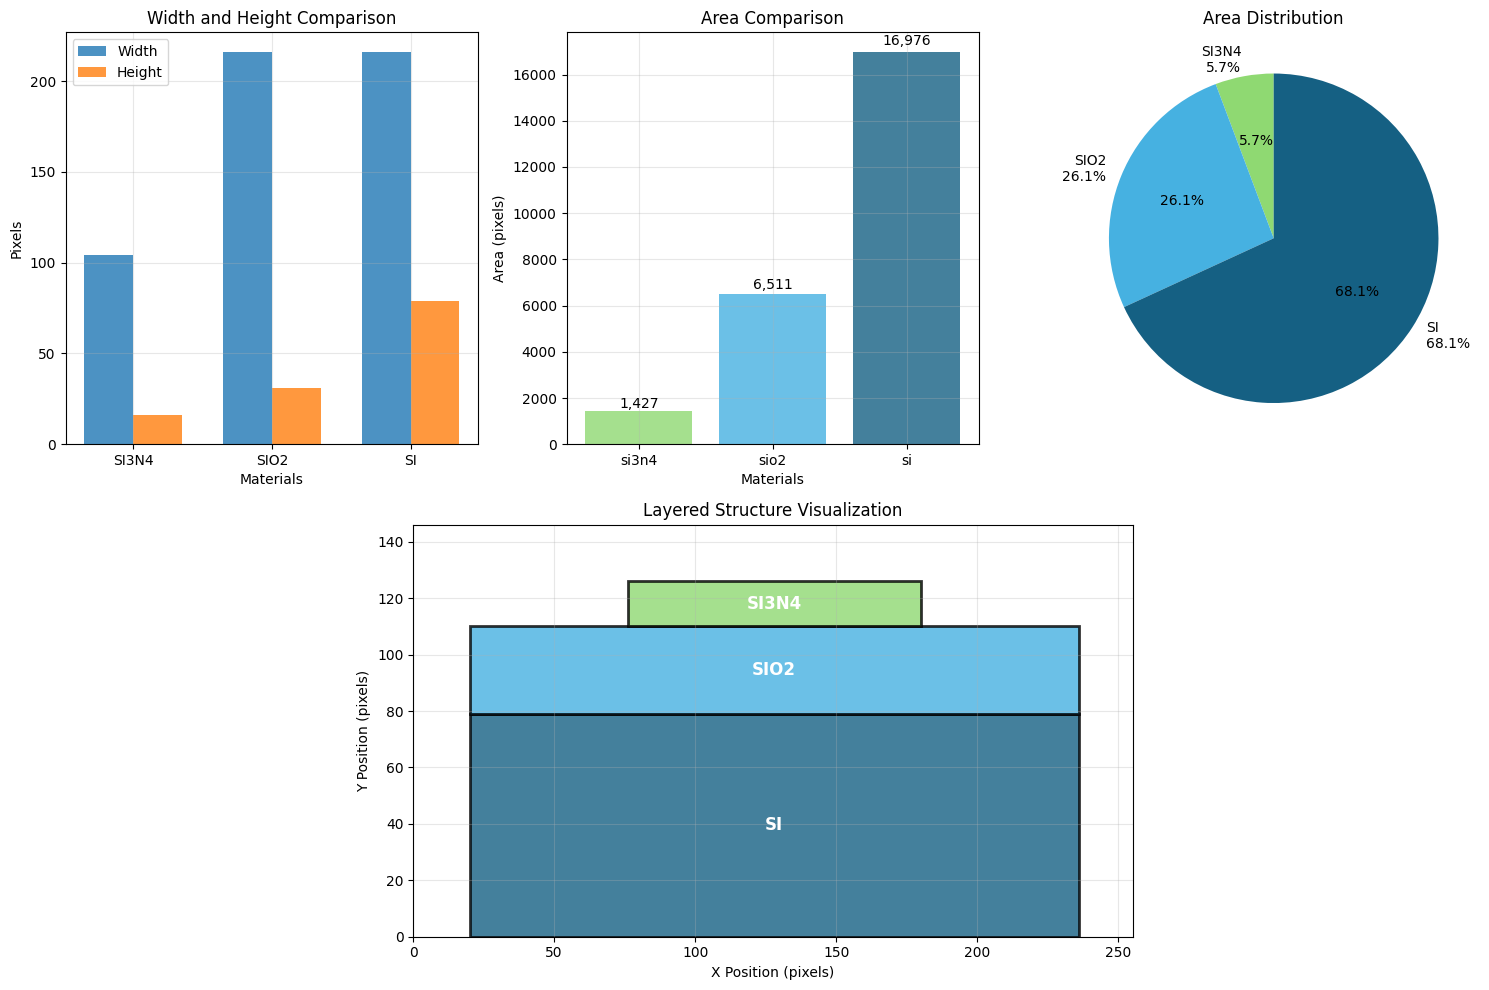

Visualization saved as 'material_analysis.png'


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

colorMap = { # hex color codes for each material
    'si3n4': "#8fd972",
    'sio2': "#46b1e1",
    'si': "#156083",
}

def hex_to_bgr(hex_color):
    """Convert hex color to BGR format for OpenCV"""
    # Remove the # if present
    hex_color = hex_color.lstrip('#')
    # Convert to RGB
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    # Return BGR (OpenCV format)
    return (b, g, r)

def hex_to_rgb(hex_color):
    """Convert hex color to RGB format for matplotlib"""
    # Remove the # if present
    hex_color = hex_color.lstrip('#')
    # Convert to RGB
    r = int(hex_color[0:2], 16) / 255.0
    g = int(hex_color[2:4], 16) / 255.0
    b = int(hex_color[4:6], 16) / 255.0
    return (r, g, b)

def color_distance(color1, color2):
    """Calculate Euclidean distance between two BGR colors"""
    return np.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(color1, color2)))

def find_material_boundaries(image, color_map, tolerance=50):
    """Find the boundaries of each material using grid-based pixel analysis"""
    height, width = image.shape[:2]
    materials = {}
    
    for material, hex_color in color_map.items():
        target_color = hex_to_bgr(hex_color)
        
        # Initialize boundaries
        min_x, max_x = width, 0
        min_y, max_y = height, 0
        pixel_count = 0
        
        # Scan the entire image pixel by pixel
        for y in range(height):
            for x in range(width):
                pixel_color = image[y, x]
                distance = color_distance(pixel_color, target_color)
                
                if distance <= tolerance:
                    # Update boundaries
                    min_x = min(min_x, x)
                    max_x = max(max_x, x)
                    min_y = min(min_y, y)
                    max_y = max(max_y, y)
                    pixel_count += 1
        
        if pixel_count > 0:
            materials[material] = {
                'min_x': min_x,
                'max_x': max_x,
                'min_y': min_y,
                'max_y': max_y,
                'width': max_x - min_x + 1,
                'height': max_y - min_y + 1,
                'area': pixel_count,
                'pixel_count': pixel_count
            }
    
    return materials

def analyze_material_distribution(image, color_map, tolerance=50):
    """Analyze the distribution of materials in the image"""
    height, width = image.shape[:2]
    material_pixels = {material: [] for material in color_map.keys()}
    
    for material, hex_color in color_map.items():
        target_color = hex_to_bgr(hex_color)
        
        for y in range(height):
            for x in range(width):
                pixel_color = image[y, x]
                distance = color_distance(pixel_color, target_color)
                
                if distance <= tolerance:
                    material_pixels[material].append((x, y))
    
    return material_pixels

def create_visualization(materials, color_map):
    """Create a comprehensive visualization of the material measurements"""
    fig = plt.figure(figsize=(15, 10))
    
    # Create subplots
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])
    
    # 1. Bar chart for dimensions
    ax1 = fig.add_subplot(gs[0, 0])
    materials_list = list(materials.keys())
    widths = [materials[m]['width'] for m in materials_list]
    heights = [materials[m]['height'] for m in materials_list]
    
    x = np.arange(len(materials_list))
    width = 0.35
    
    ax1.bar(x - width/2, widths, width, label='Width', alpha=0.8)
    ax1.bar(x + width/2, heights, width, label='Height', alpha=0.8)
    ax1.set_xlabel('Materials')
    ax1.set_ylabel('Pixels')
    ax1.set_title('Width and Height Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.upper() for m in materials_list])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Area comparison
    ax2 = fig.add_subplot(gs[0, 1])
    areas = [materials[m]['area'] for m in materials_list]
    colors = [hex_to_rgb(color_map[m]) for m in materials_list]
    
    bars = ax2.bar(materials_list, areas, color=colors, alpha=0.8)
    ax2.set_xlabel('Materials')
    ax2.set_ylabel('Area (pixels)')
    ax2.set_title('Area Comparison')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, area in zip(bars, areas):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{area:,}', ha='center', va='bottom', fontsize=10)
    
    # 3. Pie chart for area distribution
    ax3 = fig.add_subplot(gs[0, 2])
    total_area = sum(areas)
    percentages = [area/total_area*100 for area in areas]
    
    wedges, texts, autotexts = ax3.pie(areas, labels=[f'{m.upper()}\n{p:.1f}%' for m, p in zip(materials_list, percentages)], 
                                       colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Area Distribution')
    
    # 4. Layered structure visualization
    ax4 = fig.add_subplot(gs[1, :])
    
    # Sort materials by vertical position (bottom to top)
    sorted_materials = sorted(materials.items(), key=lambda x: x[1]['min_y'], reverse=True)
    
    y_offset = 0
    for material, data in sorted_materials:
        color = hex_to_rgb(color_map[material])
        rect = Rectangle((data['min_x'], y_offset), data['width'], data['height'], 
                        facecolor=color, edgecolor='black', linewidth=2, alpha=0.8)
        ax4.add_patch(rect)
        
        # Add material label
        ax4.text(data['min_x'] + data['width']/2, y_offset + data['height']/2, 
                material.upper(), ha='center', va='center', fontsize=12, fontweight='bold',
                color='white' if material in ['si', 'sio2', 'si3n4'] else 'black')
        
        y_offset += data['height']
    
    ax4.set_xlim(0, max(m['max_x'] for m in materials.values()) + 20)
    ax4.set_ylim(0, y_offset + 20)
    ax4.set_xlabel('X Position (pixels)')
    ax4.set_ylabel('Y Position (pixels)')
    ax4.set_title('Layered Structure Visualization')
    ax4.grid(True, alpha=0.3)
    ax4.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('material_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Load the image
    image_path = 'image.png'
    if not os.path.exists(image_path):
        print(f"Error: {image_path} not found!")
        return
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load {image_path}")
        return
    
    print("Grid-based Material Analysis")
    print("=" * 50)
    
    # Find material boundaries
    materials = find_material_boundaries(image, colorMap)
    
    if not materials:
        print("No materials detected. Try adjusting the tolerance value.")
        return
    
    # Print detailed measurements
    for material, data in materials.items():
        print(f"\n{material.upper()}:")
        print(f"  Position: ({data['min_x']}, {data['min_y']}) to ({data['max_x']}, {data['max_y']})")
        print(f"  Width: {data['width']} pixels")
        print(f"  Height: {data['height']} pixels")
        print(f"  Area: {data['area']} pixels")
        print(f"  Pixel count: {data['pixel_count']}")
    
    # Analyze material distribution
    print(f"\n" + "=" * 50)
    print("Material Distribution Analysis:")
    
    material_pixels = analyze_material_distribution(image, colorMap)
    
    for material, pixels in material_pixels.items():
        if pixels:
            x_coords = [p[0] for p in pixels]
            y_coords = [p[1] for p in pixels]
            
            print(f"\n{material.upper()}:")
            print(f"  Total pixels: {len(pixels)}")
            print(f"  X range: {min(x_coords)} to {max(x_coords)}")
            print(f"  Y range: {min(y_coords)} to {max(y_coords)}")
            print(f"  Center: ({np.mean(x_coords):.1f}, {np.mean(y_coords):.1f})")
    
    # Create and display visualization
    print(f"\n" + "=" * 50)
    print("Creating visualization...")
    create_visualization(materials, colorMap)
    print("Visualization saved as 'material_analysis.png'")

if __name__ == "__main__":
    main()

